In [1]:
from pathlib import Path
import sys
import os
import typing as t

current_dir = os.path.dirname(os.path.abspath(""))
print(current_dir)
sys.path.append(current_dir)

/home/ubuntu/arga-arc


In [2]:
TASK_ID = "7f4411dc" # "08ed6ac7"
ABSTRACTION = "lrg"

# evaluate GPT4 responses directly

## parse a program from gpt-4

In [3]:
FILE = (Path("..") / f"dsl/gens/gens_20231120/{TASK_ID}_correct.txt").resolve().absolute()

In [4]:
from arga_ast_generator import parse, DoOperation

print(FILE)
with open (FILE, "r") as f:
    program = f.read()

ast_program = parse(program)
programs: t.List[DoOperation] = ast_program.children

print(str(len(programs)) + " programs parsed")
print(len(programs[1].rule_list))
print(programs[1].rule_list[2])
programs[1]

/home/ubuntu/arga-arc/dsl/gens/gens_20231120/7f4411dc_correct.txt
29 programs parsed
3
RuleList(rules=[_Rule(filter_op=FilterByColor(color=Color(value='F')), transforms=Transforms(transforms=[UpdateColor(color=Color(value='A'))]))])


DoOperation(rule_list=[RuleList(rules=[_Rule(filter_op=FilterByColor(color=Color(value='O')), transforms=Transforms(transforms=[UpdateColor(color=Color(value='F'))]))]), RuleList(rules=[_Rule(filter_op=FilterByColor(color=Color(value='A')), transforms=Transforms(transforms=[UpdateColor(color=Color(value='O'))]))]), RuleList(rules=[_Rule(filter_op=FilterByColor(color=Color(value='F')), transforms=Transforms(transforms=[UpdateColor(color=Color(value='A'))]))])])

In [5]:
TASK_PATH = Path("..") / "dataset" / f"{TASK_ID}.json"

from task import Task

TASK = Task(str(TASK_PATH.resolve()))
TASK

In [6]:
from filters import setup_size_and_degree_based_on_task
from image import Image

TASK.abstraction = ABSTRACTION
TASK.input_abstracted_graphs_original[TASK.abstraction] = [
    getattr(input, Image.abstraction_ops[TASK.abstraction])() for
    input in TASK.train_input
]
TASK.get_static_object_attributes(TASK.abstraction)
setup_size_and_degree_based_on_task(TASK)

## convert the parsed program to the evaluable AST

In [7]:
from evaluate_gpt4 import convert_ast_to_executable

executable_program= convert_ast_to_executable(programs[11])
executable_program

[(<filters.FilterBySize at 0x7efe5bd628c0>,
  [<transform.UpdateColor at 0x7efe5bd62920>])]

## evaluate the transform and check if it's correct

test input <image.Image object at 0x7efe5bfb7880>
transformed[0] <image.Image object at 0x7efe5bfb7880>
test input grid [[0, 0, 0, 0, 0, 0, 0, 0, 0, 8], [0, 8, 0, 0, 0, 0, 0, 8, 0, 0], [0, 8, 8, 8, 0, 0, 0, 0, 0, 0], [0, 8, 8, 8, 0, 0, 0, 8, 0, 0], [8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 8, 8, 8, 8, 8, 8], [0, 0, 0, 0, 8, 8, 8, 8, 8, 0], [8, 0, 0, 0, 8, 8, 8, 8, 8, 0], [0, 0, 8, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 8, 0, 0, 0, 0, 8]]
transformed[0] grid [[0, 0, 0, 0, 0, 0, 0, 0, 0, 8], [0, 8, 0, 0, 0, 0, 0, 8, 0, 0], [0, 8, 8, 8, 0, 0, 0, 0, 0, 0], [0, 8, 8, 8, 0, 0, 0, 8, 0, 0], [8, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 8, 8, 8, 8, 8, 8], [0, 0, 0, 0, 8, 8, 8, 8, 8, 0], [8, 0, 0, 0, 8, 8, 8, 8, 8, 0], [0, 0, 8, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 8, 0, 0, 0, 0, 8]]


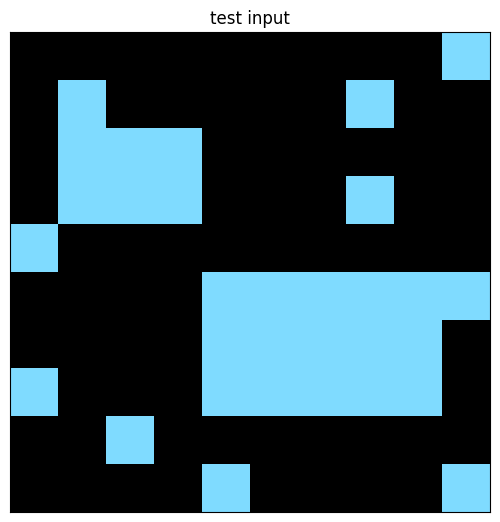

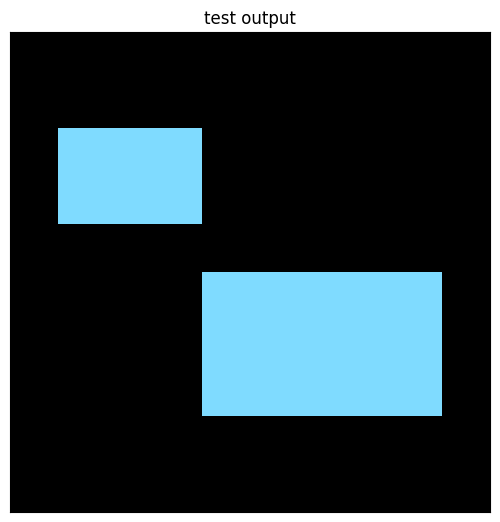

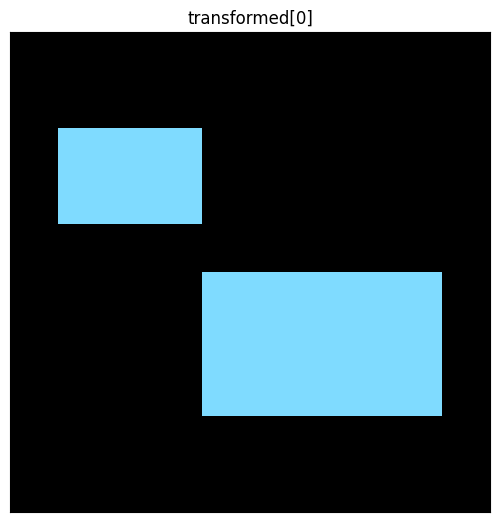

In [8]:
transformed = TASK.evaluate_program(executable_program, ABSTRACTION)
transformed
from scratch.show import print_grid

print("test input", TASK.test_input[0])
print("transformed[0]", transformed[0].image)

print("test input grid", TASK.test_input[0].grid)
print("transformed[0] grid", transformed[0].image.grid)


print_grid(TASK.test_input[0].grid, title="test input")
print_grid(TASK.test_output[0].grid, title="test output")


for idx, tf in enumerate(transformed):
    print_grid(tf.compute_grid(),title=f"transformed[{idx}]")



In [9]:
test_results = TASK.test_program(executable_program, ABSTRACTION)
print(test_results)

True


In [10]:
def compute_num_correct_programs(programs: t.List[DoOperation]) -> int:
    num_correct = 0
    for program in programs:
        executable_program = convert_ast_to_executable(program)
        test_results = TASK.test_program(executable_program, ABSTRACTION)
        if test_results:
            num_correct += 1
    return num_correct

In [11]:
compute_num_correct_programs(programs)

2